## End-to-end Machine Learning PySpark Tutorial

Now that you have PySpark up and running, we will show you how to execute an end-to-end customer segmentation project using the library. 

Customer segmentation is a marketing technique companies use  to identify and group users who display similar characteristics. For instance, if you visit Starbucks only during the summer to purchase cold beverages, you can be segmented as a “seasonal shopper” and enticed with special promotions curated for  the summer season.

Data scientists usually build unsupervised machine learning algorithms such as K-Means clustering or hierarchical clustering to perform customer segmentation. These models are great at identifying similar patterns between user groups that often go unnoticed by the human eye.

In this tutorial, we will use K-Means clustering to perform customer segmentation on the e-commerce dataset we downloaded earlier.

By the end of this tutorial, you will be familiar with the following concepts:

- Reading csv files with PySpark
- Exploratory Data Analysis with PySpark
- Grouping and sorting data
- Performing arithmetic operations
- Aggregating datasets
- Data Pre-Processing with PySpark
- Working with datetime values
- Type conversion
- Joining two dataframes
- The rank() function
- PySpark Machine Learning
- Creating a feature vector
- Standardizing data
- Building a K-Means clustering model
- Interpreting the model


### Step 1: Creating a SparkSession

A SparkSession is an entry point into all functionality in Spark, and is required if you want to build a dataframe in PySpark. Run the following lines of code to initialize a SparkSession:

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# spark = SparkSession.builder.appName("Datacamp Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

spark = SparkSession.builder.appName("Datacamp Pyspark Tutorial").getOrCreate()

Using the codes above, we built a spark session and set a name for the application. Then, the data was cached in off-heap memory to avoid storing it directly on disk, and the amount of memory was manually specified.

### Step 2: Creating the DataFrame

We can now read the dataset we just downloaded:

In [0]:

#df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/riyanwarr@gmail.com/datalab_export_2025_04_03_17_05_11.csv")
df = spark.read.csv('dbfs:/FileStore/shared_uploads/riyanwarr@gmail.com/Online_Retail.csv',header=True,escape="\"")


Note that we defined an escape character to avoid commas in the .csv file when parsing.

Let’s take a look at the head of the dataframe using the show() function:

In [0]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------

The dataframe consists of 8 variables:

- InvoiceNo: The unique identifier of each customer invoice.
- StockCode: The unique identifier of each item in stock.
- Description: The item purchased by the customer.
- Quantity: The number of each item purchased by a customer in a single invoice.
- InvoiceDate: The purchase date.
- UnitPrice: Price of one unit of each item.
- CustomerID: Unique identifier assigned to each user.
- Country: The country from where the purchase was made


### Step 3: Exploratory Data Analysis

Now that we have seen the variables present in this dataset, let’s perform some exploratory data analysis to further understand these data points:

- Let’s start by counting the number of rows in the dataframe:

In [0]:
df.count()

Out[7]: 541909

- How many unique customers are present in the dataframe?

In [0]:
df.select('CustomerID').distinct().count()

Out[8]: 4373

- What country do most purchases come from?


To find the country from which most purchases are made, we need to use the groupBy() clause in PySpark:

In [0]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

+------------------+-------------+
|           Country|country_count|
+------------------+-------------+
|            Sweden|            8|
|         Singapore|            1|
|           Germany|           95|
|               RSA|            1|
|            France|           87|
|            Greece|            4|
|European Community|            1|
|           Belgium|           25|
|           Finland|           12|
|             Malta|            2|
|       Unspecified|            4|
|             Italy|           15|
|              EIRE|            3|
|         Lithuania|            1|
|            Norway|           10|
|             Spain|           31|
|           Denmark|            9|
|         Hong Kong|            0|
|            Israel|            4|
|           Iceland|            1|
+------------------+-------------+
only showing top 20 rows



The following table will be rendered after running the codes above:

Almost all the purchases on the platform were made from the United Kingdom, and only a handful were made from countries like Germany, Australia, and France. 

Notice that the data in the table above isn’t presented in the order of purchases. To sort this table, we can include the orderBy() clause:

In [0]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



The output displayed is now sorted in descending order:



- When was the most recent purchase made by a customer on the e-commerce platform?


To find when the latest purchase was made on the platform, we need to convert the “InvoiceDate” column into a timestamp format and use the max() function in Pyspark:

In [0]:

df = df.withColumn('date', to_timestamp(col("InvoiceDate"), "M/d/yyyy H:mm"))
df.select(max("date")).show()


+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



You should see the following table appear after running the code above:



- When was the earliest purchase made by a customer on the e-commerce platform?


Similar to what we did above, the min() function can be used to find the earliest purchase date and time:

In [0]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



In [0]:
df.groupBy("CustomerID") \
  .agg(countDistinct("InvoiceDate").alias("distinct_invoice_dates")) \
  .orderBy("distinct_invoice_dates", ascending=False) \
  .show()


+----------+----------------------+
|CustomerID|distinct_invoice_dates|
+----------+----------------------+
|      null|                  3161|
|     14911|                   248|
|     12748|                   225|
|     17841|                   168|
|     14606|                   129|
|     15311|                   118|
|     13089|                   114|
|     12971|                    86|
|     14527|                    85|
|     14646|                    77|
|     13408|                    77|
|     16422|                    74|
|     16029|                    73|
|     14156|                    65|
|     13798|                    63|
|     13694|                    60|
|     18102|                    57|
|     17450|                    55|
|     15189|                    53|
|     15039|                    52|
+----------+----------------------+
only showing top 20 rows




### Step 4: Data Pre-processing

Now that we have analyzed the dataset and have a better understanding of each data point, we need to prepare the data to feed into the machine learning algorithm.

Let’s take a look at the head of the dataframe once again to understand how the pre-processing will be done:

In [0]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |84029E   |RED WOOLLY HO

### RFM - Recency Calculation in PySpark

```python
from pyspark.sql.functions import col, to_date, max, datediff, lit
```
✅ Imports necessary functions:
- `col`: Refer to DataFrame columns
- `to_date`: Converts string to Spark SQL DateType
- `max`: Retrieves maximum (latest) value
- `datediff`: Calculates difference in days between two dates
- `lit`: Treats a literal value like a date as a column

---

```python
df = df.withColumn("InvoiceDate", to_date(col("InvoiceDate"), "M/d/yyyy H:mm"))
```
✅ Converts the string in the `InvoiceDate` column to a proper date.
- Format: `"M/d/yyyy H:mm"` handles values like `"12/1/2010 8:26"`

---

```python
max_date = df.select(max("InvoiceDate")).collect()[0][0]
```
✅ Finds the **latest date** in the dataset.
- `collect()[0][0]` retrieves the actual `datetime.date` value from the result.

---

```python
recency_df = df.groupBy("CustomerID").agg(max("InvoiceDate").alias("last_purchase_date"))
```
✅ Groups by customer and gets the latest purchase date for each.

---

```python
recency_df = recency_df.withColumn("recency", datediff(lit(max_date), col("last_purchase_date")))
```
✅ Computes **recency**: the number of days since last purchase.
- Lower `recency` = more recently active customers (good!)

---

```python
display(recency_df.orderBy("recency"))
```
✅ Displays the result ordered by recency — most recent buyers come first.

---

This is the **Recency** component of RFM (Recency, Frequency, Monetary) analysis, often used in customer segmentation tasks.



In [0]:
from pyspark.sql.functions import col, to_date, max, datediff, lit

# Convert InvoiceDate to proper date format
df = df.withColumn("InvoiceDate", to_date(col("InvoiceDate"), "M/d/yyyy H:mm"))

# Find the most recent transaction date
max_date = df.select(max("InvoiceDate")).collect()[0][0]

# Get last purchase date per customer
recency_df = df.groupBy("CustomerID").agg(max("InvoiceDate").alias("last_purchase_date"))

# Calculate recency correctly
recency_df = recency_df.withColumn("recency", datediff(lit(max_date), col("last_purchase_date")))

# Display
display(recency_df.orderBy("recency"))


CustomerID,last_purchase_date,recency
16705,2011-12-09,0
17364,2011-12-09,0
15910,2011-12-09,0
12433,2011-12-09,0
null,2011-12-09,0
16954,2011-12-09,0
13113,2011-12-09,0
13069,2011-12-09,0
17389,2011-12-09,0
16558,2011-12-09,0


The output rendered should look like this:



#### Frequency

Let’s now calculate the value of frequency - how often a customer bought something on the platform. To do this, we just need to group by each customer ID and count the number of items they purchased:

In [0]:
# Step 1: Frequency = Number of transactions per customer
frequency_df = df.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('frequency'))

# Step 2: Join frequency to recency_df
rf_df = recency_df.join(frequency_df, on = 'CustomerID', how = 'inner')

# Optional: Display sorted by frequency
rf_df.orderBy('frequency', ascending = False).show()

+----------+------------------+-------+---------+
|CustomerID|last_purchase_date|recency|frequency|
+----------+------------------+-------+---------+
|     14911|        2011-12-08|      1|      248|
|     12748|        2011-12-09|      0|      224|
|     17841|        2011-12-08|      1|      169|
|     14606|        2011-12-08|      1|      128|
|     15311|        2011-12-09|      0|      118|
|     13089|        2011-12-07|      2|      118|
|     12971|        2011-12-06|      3|       89|
|     14527|        2011-12-07|      2|       86|
|     13408|        2011-12-08|      1|       81|
|     14646|        2011-12-08|      1|       77|
|     16029|        2011-11-01|     38|       76|
|     16422|        2011-11-22|     17|       75|
|     14156|        2011-11-30|      9|       66|
|     13798|        2011-12-08|      1|       63|
|     18102|        2011-12-09|      0|       62|
|     13694|        2011-12-06|      3|       60|
|     17450|        2011-12-01|      8|       55|


#### 

#### Monetary Value

Finally, let’s calculate monetary value - the total amount spent by each customer in the dataframe. There are two steps to achieving this:

##### i) Find the total amount spent in each purchase:

Each customerID comes with variables called “Quantity” and “UnitPrice” for a single purchase:



To get the total amount spent by each customer in one purchase, we need to multiply “Quantity” with “UnitPrice”:

In [0]:
df = df.withColumn("total_amount", col("Quantity")*col("UnitPrice"))

In [0]:
df.show(5,10)

+---------+---------+-----------+--------+-----------+---------+----------+----------+----------+------------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|   Country|      date|total_amount|
+---------+---------+-----------+--------+-----------+---------+----------+----------+----------+------------+
|   536365|   85123A| WHITE H...|       6| 2010-12-01|     2.55|     17850|United ...|2010-12...|  15.2999...|
|   536365|    71053| WHITE M...|       6| 2010-12-01|     3.39|     17850|United ...|2010-12...|       20.34|
|   536365|   84406B| CREAM C...|       8| 2010-12-01|     2.75|     17850|United ...|2010-12...|        22.0|
|   536365|   84029G| KNITTED...|       6| 2010-12-01|     3.39|     17850|United ...|2010-12...|       20.34|
|   536365|   84029E| RED WOO...|       6| 2010-12-01|     3.39|     17850|United ...|2010-12...|       20.34|
+---------+---------+-----------+--------+-----------+---------+----------+----------+----------+------------+
o

##### ii) Find the total amount spent by each customer:

To find the total amount spent by each customer overall, we just need to group by the CustomerID column and sum the total amount spent:

In [0]:
monetary_df = df.groupBy("CustomerID").agg(round(sum("total_amount"),2).alias("monetary_value"))

In [0]:
monetary_df.show(5,8)

+----------+--------------+
|CustomerID|monetary_value|
+----------+--------------+
|     16250|        389.44|
|     15574|        702.25|
|     15555|        4758.2|
|     15271|       2485.82|
|     17714|         153.0|
+----------+--------------+
only showing top 5 rows



In [0]:
rfm_df=rf_df.join(monetary_df,on="CustomerID", how="inner")

In [0]:
rfm_df.orderBy("monetary_value", ascending = False).show()

+----------+------------------+-------+---------+--------------+
|CustomerID|last_purchase_date|recency|frequency|monetary_value|
+----------+------------------+-------+---------+--------------+
|     14646|        2011-12-08|      1|       77|     279489.02|
|     18102|        2011-12-09|      0|       62|     256438.49|
|     17450|        2011-12-01|      8|       55|     187482.17|
|     14911|        2011-12-08|      1|      248|     132572.62|
|     12415|        2011-11-15|     24|       26|     123725.45|
|     14156|        2011-11-30|      9|       66|     113384.14|
|     17511|        2011-12-07|      2|       46|      88125.38|
|     16684|        2011-12-05|      4|       31|      65892.08|
|     13694|        2011-12-06|      3|       60|       62653.1|
|     15311|        2011-12-09|      0|      118|      59419.34|
|     13089|        2011-12-07|      2|      118|      57385.88|
|     14096|        2011-12-05|      4|       34|      57120.91|
|     15061|        2011-

In [0]:
final_df = rfm_df.select(["recency","frequency", "monetary_value","CustomerID"])

In [0]:
final_df.head()

Out[24]: Row(recency=177, frequency=4, monetary_value=702.25, CustomerID='15574')

#### Standardization

Before building the customer segmentation model, let’s standardize the dataframe to ensure that all the variables are around the same scale:

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(final_df)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [0]:
data_scale_output.select('standardized').show(2,truncate=False)

+----------------------------------------------------------+
|standardized                                              |
+----------------------------------------------------------+
|[1.756437852815102,0.4283226573841906,0.08543868008231899]|
|[0.11908053239424421,2.141613286920953,0.5789025668461234]|
+----------------------------------------------------------+
only showing top 2 rows



These are the scaled features that will be fed into the clustering algorithm.

### Step 5: Building the Machine Learning Model

Now that we have completed all the data analysis and preparation, let’s build the K-Means clustering model. 

The algorithm will be created using PySpark’s [machine learning API](https://spark.apache.org/docs/2.3.0/api/python/pyspark.ml.html).

#### i) Finding the number of clusters to use

When building a K-Means clustering model, we first need to determine the number of clusters or groups we want the algorithm to return. If we decide on three clusters, for instance, then we will have three customer segments.

The most popular technique used to decide on how many clusters to use in K-Means is called the “elbow-method.”

This is done simply running the K-Means algorithm for a wide range of clusters and visualizing the model results for each cluster. The plot will have an inflection point that looks like an elbow, and we just pick the number of clusters at this point.

Read this Datacamp [K-Means clustering tutorial](https://www.datacamp.com/tutorial/k-means-clustering-python) to learn more about how the algorithm works.

Let’s run the following lines of code to build a K-Means clustering algorithm from 2 to 6 clusters:

In [0]:
from pyspark.ml.clustering import KMeans

max_k = 6

cost = np.zeros(max_k)

for i in range(2, max_k):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

With the codes above, we have successfully built and evaluated a K-Means clustering model with 2 to 6 clusters. The results have been placed in an array, and can now be visualized in a line chart:

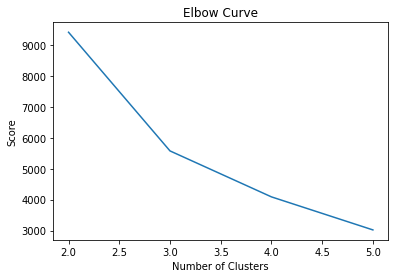

In [0]:
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2, max_k)
df_cost.insert(0, 'cluster', new_col)
plt.plot(df_cost.cluster, df_cost.cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### Use Silhouette Score for further clarity to choose the optimal value of K
The Elbow Curve is steep at two points 3 and 4. for further analysis I am going to use Silhouette score for k =3 and k= 4, if the silhouette score comes close to 1 that the value of k I want to choose.

In [0]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(
    predictionCol='prediction',
    featuresCol='standardized',
    metricName='silhouette',
    distanceMeasure='squaredEuclidean'
)

# For k=3
kmeans_3 = KMeans(featuresCol='standardized', k=3).fit(data_scale_output)
output_3 = kmeans_3.transform(data_scale_output)
score_3 = evaluator.evaluate(output_3)

# For k=4
kmeans_4 = KMeans(featuresCol='standardized', k=4).fit(data_scale_output)
output_4 = kmeans_4.transform(data_scale_output)
score_4 = evaluator.evaluate(output_4)

print("Silhouette Score for k=3:", score_3)
print("Silhouette Score for k=4:", score_4)


Silhouette Score for k=3: 0.7122268157100795
Silhouette Score for k=4: 0.7770794370576459


### 📊 Silhouette Score Comparison:

| k   | Silhouette Score |
|-----|------------------|
| 3   | 0.712            |
| 4   | **0.777 ✅**      |

### ✅ What This Means:
- The Silhouette Score for k=4 is higher, and it's quite a good score (>0.7), indicating well-separated and compact clusters.

- This means your clusters are more distinct at k=4, and it's statistically better than k=3.


The codes above will render the following chart:



#### ii) Building the K-Means Clustering Model

From the plot above and Silhouette Score , we can see that there is an inflection point that looks like an elbow at 4 and 0.77 silhouette score closer to 1. Due to this, we will proceed to build the K-Means algorithm with 4 clusters:

In [0]:
kmeans_final = KMeans(featuresCol='standardized', k=4)
model = kmeans_final.fit(data_scale_output)

#### iii) Making Predictions

Let’s use the model we created to assign clusters to each customer in the dataset:

In [0]:
final_output = model.transform(data_scale_output)

final_output.show(5,0)

+-------+---------+--------------+----------+------------------+------------------------------------------------------------+----------+
|recency|frequency|monetary_value|CustomerID|features          |standardized                                                |prediction|
+-------+---------+--------------+----------+------------------+------------------------------------------------------------+----------+
|177    |4        |702.25        |15574     |[177.0,4.0,702.25]|[1.756437852815102,0.4283226573841906,0.08543868008231899]  |1         |
|12     |20       |4758.2        |15555     |[12.0,20.0,4758.2]|[0.11908053239424421,2.141613286920953,0.5789025668461234]  |0         |
|261    |2        |389.44        |16250     |[261.0,2.0,389.44]|[2.5900015795748113,0.2141613286920953,0.047380903625857326]|1         |
|320    |1        |153.0         |17714     |[320.0,1.0,153.0] |[3.175480863846512,0.10708066434604765,0.018614621648408408]|1         |
|7      |16       |2485.82       |15271  

Notice that there is a “prediction” column in this dataframe that tells us which cluster each CustomerID belongs to:



### Step 6: Cluster Analysis

The final step in this entire tutorial is to analyze the customer segments we just built.

Run the following lines of code to visualize the recency, frequency, and monetary value of each customerID in the dataframe:

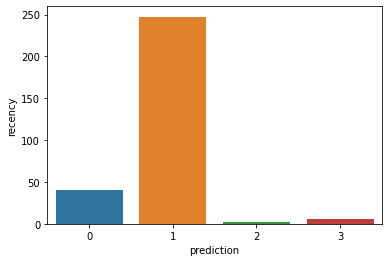

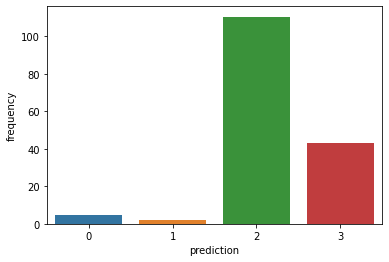

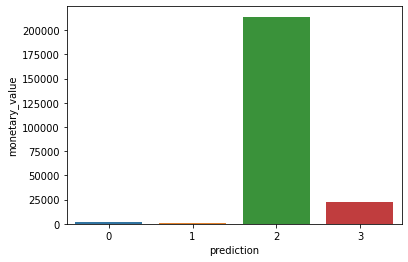

In [0]:
df_viz = final_output.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

The codes above will render the following plots:







Here is an overview of characteristics displayed by customers in each cluster:

- Cluster 0: Customers in this segment display low recency, frequency, and monetary value. They rarely shop on the platform and are low potential customers who are likely to stop doing business with the ecommerce company.


 

- Cluster 1: Users in this cluster display high recency but haven’t been seen spending much on the platform. They also don’t visit the site often. This indicates that they might be newer customers who have just started doing business with the company.


 

- Cluster 2: Customers in this segment display low recency and high frequency and spend a lot of money on the platform. This indicates that they tend to buy high-value items or make bulk purchases.


 

- Cluster 3: The final segment comprises users who display high recency and make frequent purchases on the platform. However, they don’t spend much on the platform, which might mean that they tend to select cheaper items in each purchase.



### Next Steps
Attach Cluster Labels to Customers for further analysis


In [0]:
finaldf_with_labels = final_output.select('CustomerID', 'recency', 'frequency', 'monetary_value', 'prediction')


In [0]:
from pyspark.sql.functions import when, col

labeled_df = finaldf_with_labels.withColumn(
    "segment",
    when(col("prediction") == 0, "Occasional Shoppers")
    .when(col("prediction") == 1, "At Risk")
    .when(col("prediction") == 2, "Ultra VIP")
    .when(col("prediction") == 3, "High Value")
)


### Visualize Cluster Counts
Let's start by visualizing the count of customers in each segment

In [0]:
import plotly.express as px

df_viz = labeled_df.select('recency', 'frequency', 'monetary_value', 'prediction', 'segment')
df_viz = df_viz.toPandas()

# Count of customers per cluster
cluster_counts = df_viz['prediction'].value_counts().sort_index()

# Map the cluster IDs to segment labels
cluster_to_segment = df_viz.drop_duplicates(subset=['prediction', 'segment']).set_index('prediction')['segment'].to_dict()

# Replace cluster IDs with segment labels
cluster_labels = [cluster_to_segment[cluster_id] for cluster_id in cluster_counts.index]

# Create an interactive pie chart with Plotly
fig = px.pie(
    names=cluster_labels, 
    values=cluster_counts.values, 
    title='Customer Distribution per Segment',
    color=cluster_labels,
    color_discrete_sequence=px.colors.qualitative.Set1  
)

# Show the plot
fig.show()
